# Create a GIF with the FireRP and Precipitation data

In [1]:
from PIL import Image
import numpy as np

In [22]:
from platform import python_version
print('Python: ' + python_version())
print('PIL: ' + Image.__version__)
print('numpy: ' + np.__version__)

Python: 3.12.2
PIL: 10.2.0
numpy: 1.26.4


### loading required data

In [2]:
datacube_precip = np.load("./data/WaterPrecip_datacube.npy")
datacube_FireRF = np.load("./data/FireRP_log_datacube_MWIR.npy")

time_precip = np.load("./data/WaterPrecip_time.npy")
time_FireRF = np.load("./data/FireRP_time.npy")

latitude = np.load("./data/WaterPrecip_latitude.npy")
longitude = np.load("./data/WaterPrecip_longitude.npy")

## Create color scale for the plot
### to_RGB_white
FireRP: white -> orange -> red \
Precipitation: white -> light blue -> dark blue \
Coexistance of Fire and Rain: white -> magenta

In [3]:
# Helper function for to_RGB_white
# see 2Dcolorsheme.odt for the derivation of the formula
def calc_v(x,y):
    return max(min(x,1)-y + max((x+y-2)/2,0),0)

# Input: red and blue value normalized to the range [0,2]
# Output: RGB value tuple
def to_RGB_white(red, blue):
    return ((1-calc_v(blue,red))*255, 
     (1-max(red,blue)/2)*255, 
     (1-calc_v(red,blue))*255)

### Sample the 2D gradient

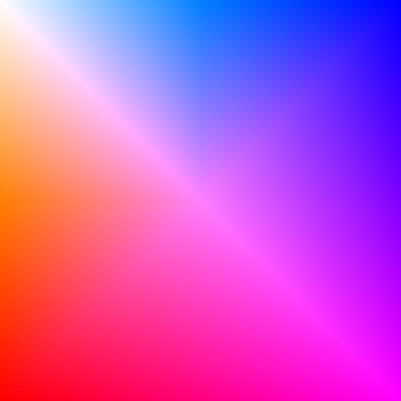

In [4]:
# create a 2D array of values ranging from [0 to 2] with 0.005 increments
temp = [[to_RGB_white(x,y)
         for y in np.arange(0,2.001,0.005)] 
        for x in np.arange(0,2.001,0.005)]
# Convert the pixels into an array using numpy
array = np.array(temp, dtype=np.uint8)
# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array)
new_image

### to_RGB_black
Increased the contrast of the overlap \
FireRP: white -> orange -> red \
Precipitation: white -> light blue -> dark blue \
Coexistance of Fire and Rain: white -> magenta -> black

In [5]:
# Helper function for to_RGB_black
# see 2Dcolorsheme.odt for the derivation of the formula
def calc_p(x,y):
    return max(max(min(x,1)-y,0),x-1, (x+y-2)/2,0)
    # return max(max(max(min(x,1)-y,0),x-1), max((x+y-2)/2,0),0)

# Input: red and blue value normalized to the range [0,1]
# Output: RGB value tuple
def to_RGB_black(red, blue):
    return ((1-calc_p(blue,red))*255, 
     (max(2-red-blue,0)/2)*255, 
     (1-calc_p(red,blue))*255)

### Sample the 2D gradient

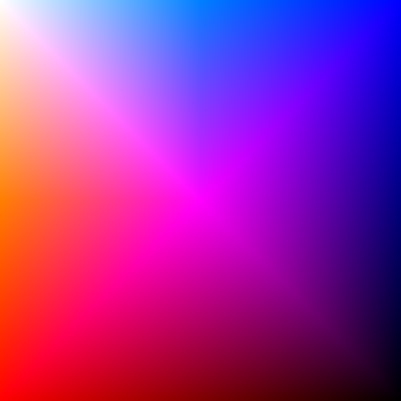

In [6]:
# create a 2D array of values ranging from [0 to 2] with 0.005 increments
temp = [[to_RGB_black(x,y)
         for y in np.arange(0,2.001,0.005)] 
        for x in np.arange(0,2.001,0.005)]
# Convert the pixels into an array using numpy
array = np.array(temp, dtype=np.uint8)
# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array)
new_image

## Normalize the data to [0,2]
1) subtract the minimum
2) divide by the maximum
3) multiply by 2

In [7]:
datacube_FireRF = datacube_FireRF - datacube_FireRF.min()
datacube_FireRF = datacube_FireRF/datacube_FireRF.max() * 2

In [8]:
# set the missing values encodes as -99999 to 0
datacube_precip[datacube_precip == -99999] = 0
datacube_precip = datacube_precip - datacube_precip.min()
datacube_precip = datacube_precip/datacube_precip.max() * 2

## Create a function to add numbers to the image

In [9]:
# a dictionary of pixel representation of numbers
# see the 123.png
num_dict = dict({0: [(0,0), (0,1), (0,2), (1,0), (1,2), (2,0), (2,2), (3,0), (3,2), (4,0), (4,1), (4,2)],
             1: [(0,1), (1,0), (1,1), (2,1), (3,1), (4,0), (4,1), (4,2)],
             2: [(0,0), (0,1), (0,2), (1,2), (2,0), (2,1), (2,2), (3,0), (4,0), (4,1), (4,2)],
             3: [(0,0), (0,1), (0,2), (1,2), (2,1), (2,2), (3,2), (4,0), (4,1), (4,2)],
             4: [(0,0), (0,2), (1,0), (1,2), (2,0), (2,1), (2,2), (3,2), (4,2)],
             5: [(0,0), (0,1), (0,2), (1,0), (2,0), (2,1), (2,2), (3,2), (4,0), (4,1), (4,2)],
             6: [(0,0), (0,1), (0,2), (1,0), (2,0), (2,1), (2,2), (3,0), (3,2), (4,0), (4,1), (4,2)],
             7: [(0,0), (0,1), (0,2), (1,2), (2,2), (3,2), (4,2)],
             8: [(0,0), (0,1), (0,2), (1,0), (1,2), (2,0), (2,1), (2,2), (3,0), (3,2), (4,0), (4,1), (4,2)],
             9: [(0,0), (0,1), (0,2), (1,0), (1,2), (2,0), (2,1), (2,2), (3,2), (4,2)]
            })

In [10]:
# Input img_arr: image array to be modified
# Input n: number to add
# modify the Input arr inplace and add the value at 100, 10, and 1 to the upper right of the image in black (0,0,0)
def add_num(img_arr, n):
    for x,y in num_dict[int((n%1000)/100)]:
        img_arr[x+1][y+1] = (0,0,0)
    for x,y in num_dict[int((n%100)/10)]:
        img_arr[x+1][y+5] = (0,0,0)
    for x,y in num_dict[int(n%10)]:
        img_arr[x+1][y+9] = (0,0,0)
        

### Test the function by adding the number 365 to a white canvas

In [11]:
# create a 20 by 20 white canvas
# list comprehension used to avoid coping the reference
temp = [[(255,255,255)]*20 for _ in range(20)]
# add the number 365 to the canvas
add_num(temp, 365)
# Convert the pixels into an array using numpy
array = np.array(temp, dtype=np.uint8)
# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array)
new_image

### Test the complete algorithm on one time slice

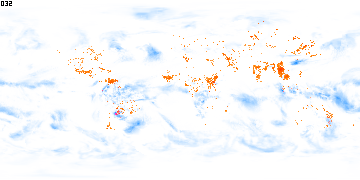

In [12]:
# INPUT: select a function to generate the RGB values (to_RGB_white or to_RGB_black)
pfun = to_RGB_black
# INPUT: select a time slice
n = 32
# select the coresponding date to the time slice
date = time_FireRF[n]
# transform the normalized FireRP and Precipitation data to RGB values with the custom colour scale
temp = [[pfun(x,y)
         for x,y in zip(i,j)]
        for i, j in zip(
            datacube_FireRF[np.argwhere(time_FireRF == date)[0][0],:,:],
            datacube_precip[np.argwhere(time_precip == date)[0][0],:,:]
        )]
# add the slice number to the canvas
add_num(temp[::-1], n)
# Convert the pixels into an array using numpy
array = np.array(temp[::-1], dtype=np.uint8)
# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array)
new_image

In [14]:
new_image.save('./FW_' + str(time_FireRF[n]) + '.png')

### Look for the time slice containing the most magenta value (overlap FireRP and Precipitation)

In [97]:
# INPUT: select a function to generate the RGB values (to_RGB_white or to_RGB_black)
pfun = to_RGB_black
# create an empty list to store the arrays
arr = []
for i, date in enumerate(time_FireRF):
    # transform the normalized FireRP and Precipitation data to RGB values with the custom colour scale
    temp = [[pfun(x,y)
             for x,y in zip(i,j)]
            for i, j in zip(
        datacube_FireRF[np.argwhere(time_FireRF == date)[0][0],:,:],
        datacube_precip[np.argwhere(time_precip == date)[0][0],:,:]
    )]
    # Convert the pixels into an array using numpy
    array = np.array(temp[::-1], dtype=np.uint8)
    arr.append(array)

In [94]:
arr = np.array(arr)
test = (arr[:,:,:,0] > 250) & (arr[:,:,:,1] < 50) & (arr[:,:,:,2] > 250)
[i for i,x in enumerate(test.sum(axis = (1,2))) if x]

[32]

## Run the complete algorithm to create the GIF

In [75]:
# INPUT: select a function to generate the RGB values (to_RGB_white or to_RGB_black)
pfun = to_RGB_black
# create an empty list to store the images
images = []
# add all time slices to the list
# the Precipitation contains more timepoint than FireRF
for i, date in enumerate(time_FireRF):
    # transform the normalized FireRP and Precipitation data to RGB values with the custom colour scale
    temp = [[to_RGB_black(x,y)
             for x,y in zip(i,j)]
            for i, j in zip(
        datacube_FireRF[np.argwhere(time_FireRF == date)[0][0],:,:],
        datacube_precip[np.argwhere(time_precip == date)[0][0],:,:]
    )]
    # add the slice number to the canvas
    add_num(temp[::-1], i)
    # Convert the pixels into an array using numpy
    array = np.array(temp[::-1], dtype=np.uint8)
    # Use PIL to create an image from the new array of pixels
    new_image = Image.fromarray(array)
    images.append(new_image)

In [78]:
# duration in milliseconds
dur = 500
# file name
name_gif = "FireWater_b_03"
# save the image stack as a gif
images[0].save('./' + name_gif + '.gif',
               save_all=True, append_images=images[1:], 
               optimize=False, duration=dur, loop=0)